This is a very rough version. I used lots of buffering because the various UTM zones make it harder to get all the data at once. Buffers are heuristic!

In [1]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from osgeo import gdal
from pathlib import Path
from dem_stitcher.rio_window import read_raster_from_window
from dem_stitcher.rio_tools import reproject_arr_to_new_crs, reproject_arr_to_match_profile
import concurrent.futures

# Generate Tile Map

In [2]:
df_zones = gpd.read_file('s2_class_zones.geojson')
df_zones.head()

,zone,geometry
0,01C,"POLYGON ((-174.00377 -79.97089, -174.00377 -71..."
1,01G,"POLYGON ((-174.00181 -47.98783, -174.00181 -39..."
2,01K,"POLYGON ((-174.00041 -23.99679, -174.00041 -15..."
3,01L,"POLYGON ((-174.00011 -15.99869, -174.00011 -7...."
4,01U,"POLYGON ((-173.41267 47.96096, -173.41267 55.9..."


<AxesSubplot:>

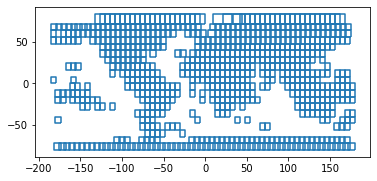

In [3]:
df_zones.boundary.plot()

In [4]:
df_chips = gpd.read_file('chips.geojson')
df_chips.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-159.648125,69.21,3,3_38,2011-07-17,1,99,"POLYGON ((-159.89875 69.30000, -159.65900 69.3..."
1,-112.983750,67.05,4,4_27,2012-07-23,1,114,"POLYGON ((-113.21200 67.14000, -113.09850 67.1..."
2,17.698500,65.97,4,4_43,2010-07-24,1,20,"POLYGON ((17.61000 66.06000, 17.91700 66.06000..."
3,59.675000,65.79,3,3_1,2011-07-13,1,112,"POLYGON ((59.86900 65.88000, 59.89200 65.88000..."
4,-96.604375,62.73,4,4_34,2012-08-27,1,115,"POLYGON ((-96.79875 62.82000, -96.57700 62.820..."


Reference url is 'https://lulctimeseries.blob.core.windows.net/lulctimeseriespublic/lc2021/17M_20210101-20220101.tif'

In [5]:
def generate_url(zone, year=2021):
    assert(year in list(range(2017, 2022)))
    base_url = 'https://lulctimeseries.blob.core.windows.net/lulctimeseriespublic'
    url = f'{base_url}/lc{year}/{zone}_{year}0101-{year+1}0101.tif'
    return url

In [6]:
url = generate_url('16Q', 2017)
print(url)

https://lulctimeseries.blob.core.windows.net/lulctimeseriespublic/lc2017/16Q_20170101-20180101.tif


In [7]:
def get_s2_urls(extent: list,
                year=2021):
    bbox = box(*extent).buffer(.1)
    ind_inter = df_zones.geometry.intersects(bbox)
    df_subset = df_zones[ind_inter].reset_index(drop=True)
    
    df_subset['int_area'] = df_subset.geometry.intersection(bbox).area
    df_subset = df_subset.sort_values(by='int_area', ascending=False).reset_index(drop=True)

    df_subset.to_file('subset_test')
    zones = df_subset.zone.unique()
    def generate_url_p(zone):
        return generate_url(zone, year=year)
    urls = list(map(generate_url_p, zones))
    return urls

In [8]:
chip_id = 42
bounds_4326 = df_chips[df_chips.random_id == chip_id].total_bounds
bounds_4326

array([-95.97375,  32.94   , -95.76   ,  33.12   ])

In [9]:
with rasterio.open(url) as ds:
    p = ds.profile
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 64219, 'height': 88854, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(9.999999999999996, 0.0, 178903.29477130197,
       0.0, -10.0, 2657476.7234801855), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [10]:
urls = get_s2_urls(bounds_4326, year=2021)
urls

/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_31732/1882217597.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_subset['int_area'] = df_subset.geometry.intersection(bbox).area


['https://lulctimeseries.blob.core.windows.net/lulctimeseriespublic/lc2021/14S_20210101-20220101.tif',
 'https://lulctimeseries.blob.core.windows.net/lulctimeseriespublic/lc2021/15S_20210101-20220101.tif']

# Localize Files

In [11]:
def localize_one_raster(raster_path: str,
                        extent: list,
                        out_dir) -> Path:
    X, p = read_raster_from_window(raster_path,
                                   extent,
                                   CRS.from_epsg(4326),
                                   res_buffer=100)
    
    file_name = raster_path.split('/')[-1]
    out_path = Path(f'{out_dir}/{file_name}')
    
    X[(X >= 12) | (X <= 0)] = p['nodata']
    
    with rasterio.open(out_path, 'w', **p) as ds:
        ds.write(X, 1)
    return out_path

def localize_rasters(paths: list,
                     extent: list,
                     out_dir: Path = Path('tmp')):
    
    out_dir.mkdir(exist_ok=True)
    
    def localize_p(path):
        return localize_one_raster(path,
                                   extent,
                                   out_dir)
    
    out_paths = list(map(localize_p, tqdm(paths, desc='localizing rasters')))
    return out_paths

In [12]:
paths = localize_rasters(urls, bounds_4326)

localizing rasters: 100%|███████████████████| 2/2 [00:03<00:00,  1.79s/it]


In [13]:
def get_bbox_geo_area(path):
    with rasterio.open(path) as ds:
        bounds = list(ds.bounds)
    return box(*bounds).area

def order_paths_by_area(paths):
    areas = list(map(get_bbox_geo_area, paths))
    print(areas)
    return [p for _, p in sorted(zip(areas, paths), reverse=True)]

def align_one_crs(path, ref_crs):
    with rasterio.open(path) as ds:
        src_profile = ds.profile
        if src_profile['crs'] != ref_crs:
            X = ds.read(1)
        else:
            return path
    X, p = reproject_arr_to_new_crs(X, src_profile, ref_crs)
    X = X[0, ...]
    with rasterio.open(path, 'w', **p) as ds:
        ds.write(X, 1)
    return path

def align_all_crs(paths):
    with rasterio.open(paths[0]) as ds:
        ref_crs = ds.crs
    def align_one_crs_p(path):
        return align_one_crs(path, ref_crs)
    paths = list(map(align_one_crs_p, tqdm(paths)))
    return paths

In [14]:
paths = order_paths_by_area(paths)
paths = align_all_crs(paths)
paths

[33403600.0, 482817900.0]


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 25.79it/s]


[PosixPath('tmp/15S_20210101-20220101.tif'),
 PosixPath('tmp/14S_20210101-20220101.tif')]

# Merge Files

In [15]:
from rasterio.merge import merge

In [16]:
def merge_tiles(paths):
    with rasterio.open(paths[0]) as ds:
        p = ds.profile
    X, t = merge(paths, nodata=p['nodata'], method='first')
    X = X[0, ...]
    p_merged = p.copy()
    p['width'] = X.shape[1]
    p['height'] = X.shape[0]
    p['transform'] = t
    return X, p

In [17]:
X, p_merged = merge_tiles(paths)

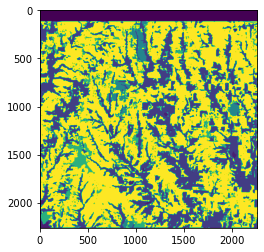

In [18]:
plt.imshow(X)

In [19]:
with rasterio.open('merged_out.tif', 'w', **p_merged) as ds:
    ds.write(X, 1)